In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV ,SGDClassifier
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
print(os.getcwd())
file_path = './primerParcial/datasets/datos_CB.csv'
student_data = pd.read_csv(file_path,index_col=0)
student_data.info()

C:\Users\josec\Documents\FIUNA\9no\IA\datosRendimiento
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97341 entries, 401 to 12388
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ciclo         97341 non-null  int64  
 1   Asignatura    97341 non-null  object 
 2   Convocatoria  97341 non-null  int64  
 3   Anho          97341 non-null  int64  
 4   Aprobado      97341 non-null  int64  
 5   Anho.Firma    97341 non-null  int64  
 6   Primer.Par    97341 non-null  int64  
 7   Segundo.Par   97341 non-null  int64  
 8   AOT           97341 non-null  int64  
 9   Nota.Final    97341 non-null  object 
 10  id_anony      97341 non-null  object 
 11  Nota.Prom     97341 non-null  float64
dtypes: float64(1), int64(8), object(3)
memory usage: 9.7+ MB


In [3]:
student_data.head()

,ciclo,Asignatura,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony,Nota.Prom
401,1,CALCULO 3,1,2012,0,0,0,0,0,[0],es_253,0.0
402,1,FISICA 4,1,2012,0,2012,19,13,9,[0],es_254,0.0
403,1,FISICA 4,1,2012,1,2012,17,24,10,[3],es_255,3.0
404,1,FISICA 4,1,2012,0,0,0,0,0,[0],es_256,0.0
405,1,FISICA 4,1,2012,0,0,16,12,8,[0],es_257,0.0


In [4]:
def get_course(student_data,course):
    condition = student_data["Asignatura"] == course
    course_data = student_data[condition]
    course_data.drop(["Nota.Prom"],axis=1, inplace = True)
    print("\n",len(course_data))
    course_data.head()
    return course_data

In [5]:
course_data = get_course(student_data,'ESTATICA')
course_data.head()


 4824


C:\Users\josec\AppData\Local\Temp\ipykernel_14444\1341986020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_data.drop(["Nota.Prom"],axis=1, inplace = True)


,ciclo,Asignatura,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony
1744,2,ESTATICA,1,2012,0,0,2,13,0,[0],es_469
1745,2,ESTATICA,1,2012,0,0,6,11,0,[0],es_470
1746,2,ESTATICA,1,2012,1,2012,12,24,0,[2],es_175
1747,2,ESTATICA,1,2012,0,0,1,1,0,[0],es_910
1748,2,ESTATICA,1,2012,0,0,0,0,0,[0],es_1475


# Making a new column with number of attemps

In [6]:
def count_attemps(course_data):
    course_data = course_data.sort_values(by=['id_anony','Anho'])
    last_id = course_data['id_anony'].iloc[0]
    counter = 0
    for index,row in course_data.iterrows():
        #print(index)
        if row['id_anony'] == last_id:
            counter += 1 
            course_data.loc[index,['Num.Intento']] = counter
        else:
            last_id = row['id_anony']
            course_data.loc[index,['Num.Intento']] = 1
            counter = 1
    return course_data

In [7]:
course_data = count_attemps(course_data)

# Heat map to check corr

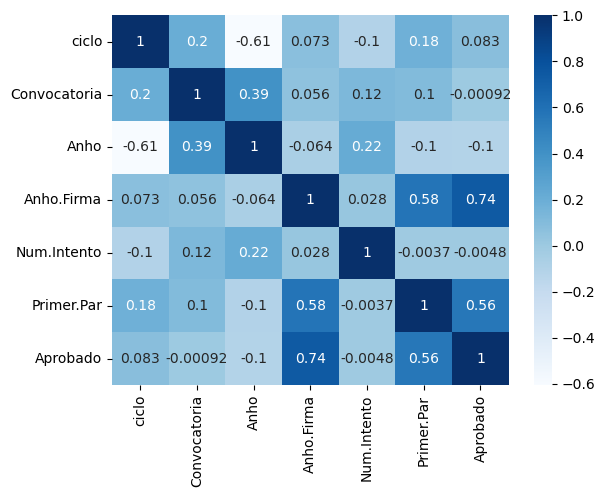

In [8]:
sns.heatmap(course_data[['ciclo','Convocatoria','Anho','Anho.Firma','Num.Intento','Primer.Par','Aprobado']].corr(), cmap='Blues', annot=True)
plt.show()

# Adding previous course data

In [9]:
def get_previous_course(previous_course):
    #slicing
    formated_title = str.title(previous_course.lower().replace(' ', '_'))
    condition = student_data["Asignatura"] == previous_course
    previous_course_data = student_data[condition]
    previous_course_data = count_attemps(previous_course_data)
    previous_course_data = previous_course_data.rename(columns={'Num.Intento':f'Num.Intento.{formated_title}', 'Nota.Prom' : f'Nota.Prom.{formated_title}'})
    previous_course_data = previous_course_data[["id_anony", f'Nota.Prom.{formated_title}', f'Num.Intento.{formated_title}']]
    
    #grouping by id
    attemps = previous_course_data[['id_anony',f'Num.Intento.{formated_title}']].groupby(['id_anony']).max()
    avg_grade = previous_course_data[['id_anony',f'Nota.Prom.{formated_title}']].groupby(['id_anony']).mean()
    result = pd.concat([avg_grade,attemps],axis=1)
    #result
    
    return result

In [10]:
def merge_previous_course(course_data,result):
    result = pd.merge(course_data, result, on = 'id_anony', how = 'left')
    #for col in result.columns:
    #    print(col,np.unique(result[col]))
    return result


In [11]:
def getNans(result):
    course = result.columns[-1][12:] #get the previous course name
    print("Mean grade with NaN:",np.mean(result.iloc[:,-2]),"Mean attemps with NaN:",np.mean(result.iloc[:,-1]))
    result[f'Nota.Prom.{course}'] = result[f'Nota.Prom.{course}'].fillna(result['Primer.Par']/24*5) #averagin from first midterm
    result[f'Num.Intento.{course}'] = result[f'Num.Intento.{course}'].fillna(np.mean(result[f'Num.Intento.{course}']))
    print('Mean grade interpolated',np.mean(result[f'Nota.Prom.{course}']),'Mean attemps interpolated',np.mean(result[f'Num.Intento.{course}']))


In [12]:
def add_course(course_data,previous_course):
    previous_course_data = get_previous_course(previous_course)
    result = merge_previous_course(course_data,previous_course_data)
    getNans(result)
    original = result.copy()
    y = result['Aprobado']
    result.drop(['ciclo','Asignatura','Aprobado','Segundo.Par','AOT','Anho.Firma','Nota.Final','id_anony'],axis=1,inplace = True)
    return result,y,original

In [13]:
result,y,original = add_course(course_data,'ALGEBRA LINEAL 2')

Mean grade with NaN: 1.9052710303304832 Mean attemps with NaN: 1.7153388822829965
Mean grade interpolated 1.8735312360156886 Mean attemps interpolated 1.7153388822829965


In [33]:
result

,Convocatoria,Anho,Primer.Par,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2,Nota.Prom.Fisica_1,Num.Intento.Fisica_1
0,1,2012,6,1.0,1.250000,1.715339,1.250000,1.276039
1,1,2013,6,1.0,1.250000,1.715339,1.250000,1.276039
2,1,2012,15,1.0,3.125000,1.715339,3.125000,1.276039
3,1,2012,10,1.0,2.083333,1.715339,2.083333,1.276039
4,1,2013,8,3.0,1.666667,1.715339,1.666667,1.276039
...,...,...,...,...,...,...,...,...
4819,1,2012,16,1.0,3.333333,1.715339,3.333333,1.276039
4820,1,2013,0,1.0,0.000000,1.715339,0.000000,1.276039
4821,1,2012,3,1.0,0.666667,2.000000,0.625000,1.276039
4822,1,2013,9,2.0,0.666667,2.000000,1.875000,1.276039


### Here, it could be useful to repeat this proccess (with a function) and add data for another course like Fisica 1

In [14]:
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

# Pipeline and Gridsearch

In [15]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import learning_curve

from tempfile import mkdtemp
from shutil import rmtree

In [16]:
def hyperparam_search(x,y):
    std_slc = StandardScaler()
    pca = decomposition.PCA()
    logistic_Reg = linear_model.LogisticRegression(solver='liblinear',max_iter=1000)
    cachedir = mkdtemp()

    pipe = Pipeline(steps = [('scaler', StandardScaler()), ('pca', pca), ('logistic_Reg', logistic_Reg)],memory=cachedir)
    n_components = list(range(1,x.shape[1]+1,1))

    C = np.logspace(-4, 4, 100)
    #C = [0.001, 0.01, 0.1, 1, 10, 100]
    penalty = ['l1', 'l2']

    parameters = [
        {'logistic_Reg__solver' : ['liblinear'],
            'pca__n_components' : n_components,
                          'scaler' : [StandardScaler(), MinMaxScaler()],
                          'logistic_Reg__C' : C,
                          'logistic_Reg__penalty' : penalty[0:2]},
        {'logistic_Reg__solver' : ['newton-cg', 'lbfgs','newton-cholesky'],
            'pca__n_components' : n_components,
                          'scaler' : [StandardScaler(), MinMaxScaler()],
                          'logistic_Reg__C' : C,
                          'logistic_Reg__penalty' : penalty[1:]}
                      ]


    clf_GS = GridSearchCV(pipe, parameters, scoring = 'accuracy', n_jobs=-1)
    clf_GS.fit(x, y)
    
    best_parameters = clf_GS.best_estimator_.get_params()
    for param_name in sorted(parameters[0].keys()):
        print(f"{param_name}: {best_parameters[param_name]}")
    print(f"best score: {clf_GS.best_score_}")
    print(clf_GS.best_estimator_.get_params()['logistic_Reg'])
    
    #print('Best scaler:',clf_GS.best_estimator_.get_params()['scaler'])
    #print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
    #print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
    #print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    #print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

In [17]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore')    
hyperparam_search(X_train,y_train)

Stored variables and their in-db values:
logistic_Reg__C: 0.026560877829466867
logistic_Reg__penalty: l2
logistic_Reg__solver: newton-cg
pca__n_components: 6
scaler: StandardScaler()
best score: 0.7763890480884589
LogisticRegression(C=0.026560877829466867, max_iter=1000, solver='newton-cg')


# Without tuning

In [18]:
LR = linear_model.LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

C:\Users\josec\anaconda3\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7885572139303483

# Old parameters attemp

In [19]:
n = 6
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.12648552168552957, solver='liblinear', penalty = 'l2')


pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7885572139303483

In [20]:
#without PCA
scaler = StandardScaler()
logistic_Reg = LogisticRegression(C=0.026560877829466867, max_iter=1000, solver='newton-cg')

pipe = Pipeline(steps=[('scaler', scaler), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7910447761194029

# Attemp 1

In [21]:
n = 6
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.24770763559917114, max_iter=1000, solver='newton-cg')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7918739635157546

# Confusion matrix for both

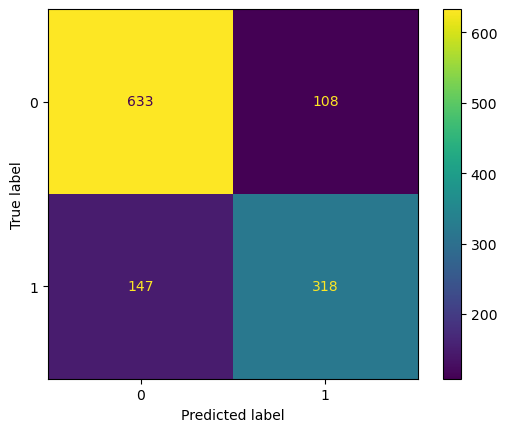

In [22]:
predictions = LR.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

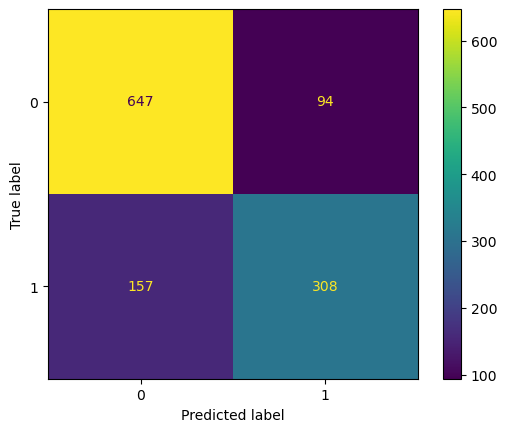

In [23]:
predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

Maybe changing the threshold could be better

# Learning curve for no tuning and tuned 

Stored variables and their in-db values:


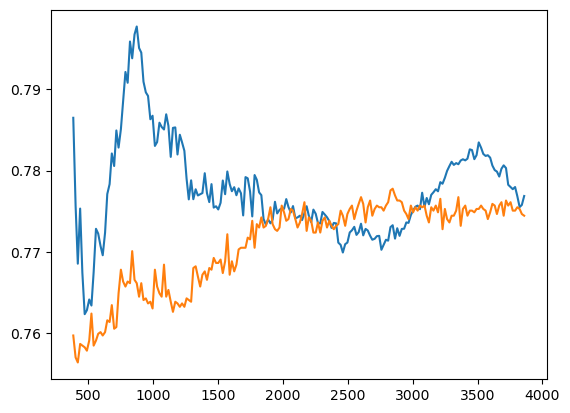

In [24]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore')   
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(LR, result, y, return_times=True, train_sizes=np.linspace(0.1, 1.0, 200))
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))

Stored variables and their in-db values:


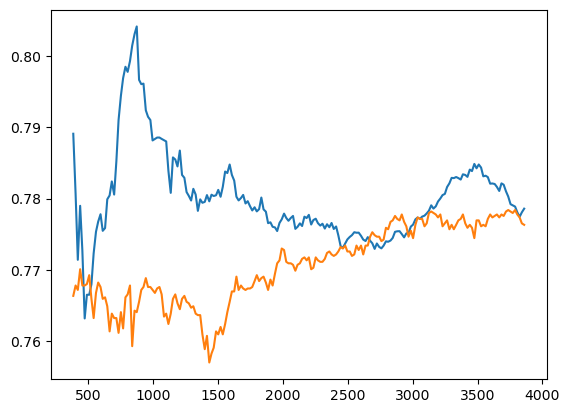

In [25]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore') 
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(logistic_Reg, result, y, return_times=True, train_sizes=np.linspace(0.1, 1.0, 200))
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))

parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]


# Adding a third course

In [26]:
result,y,original = add_course(original,'FISICA 1')

Mean grade with NaN: 2.791847688610637 Mean attemps with NaN: 1.2760387023335231
Mean grade interpolated 2.501021512806339 Mean attemps interpolated 1.2760387023335231


In [27]:
result

,Convocatoria,Anho,Primer.Par,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2,Nota.Prom.Fisica_1,Num.Intento.Fisica_1
0,1,2012,6,1.0,1.250000,1.715339,1.250000,1.276039
1,1,2013,6,1.0,1.250000,1.715339,1.250000,1.276039
2,1,2012,15,1.0,3.125000,1.715339,3.125000,1.276039
3,1,2012,10,1.0,2.083333,1.715339,2.083333,1.276039
4,1,2013,8,3.0,1.666667,1.715339,1.666667,1.276039
...,...,...,...,...,...,...,...,...
4819,1,2012,16,1.0,3.333333,1.715339,3.333333,1.276039
4820,1,2013,0,1.0,0.000000,1.715339,0.000000,1.276039
4821,1,2012,3,1.0,0.666667,2.000000,0.625000,1.276039
4822,1,2013,9,2.0,0.666667,2.000000,1.875000,1.276039


In [28]:
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

%%script false

In [30]:
LR = linear_model.LogisticRegression(max_iter=1000)
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

0.7761194029850746

In [31]:
hyperparam_search(X_train,y_train)

logistic_Reg__C: 0.298364724028334
logistic_Reg__penalty: l2
logistic_Reg__solver: newton-cg
pca__n_components: 8
scaler: MinMaxScaler()
best score: 0.7844062110757051
LogisticRegression(C=0.298364724028334, max_iter=1000, solver='newton-cg')


In [32]:
n = 8
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.298364724028334, max_iter=1000, solver='newton-cg')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.785240464344942